In [1]:
import h5py
import numpy as np
from xml.etree import ElementTree as ET
from collections import defaultdict
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
def load_h5_metadata(filename):
    with h5py.File(filename, 'r') as hf:
        kspace = hf['kspace'][:]

        if 'ismrmrd_header' in hf:
            header_str = hf['ismrmrd_header'][()]
        else:
            raise KeyError(f"'ismrmrd_header' not found in {filename}")

        if isinstance(header_str, bytes):
            header_str = header_str.decode('utf-8')

        xml_root = ET.fromstring(header_str)

    return kspace, xml_root

def parse_ismrmrd_header(xml_root):
    ns = {'ismrmrd': 'http://www.ismrm.org/ISMRMRD'}
    metadata = defaultdict(lambda: None)

    def try_find(path):
        el = xml_root.find(path, ns)
        return el.text if el is not None else None

    # Acquisition system
    metadata['field_strength'] = try_find('./ismrmrd:acquisitionSystemInformation/ismrmrd:systemFieldStrength_T')
    metadata['system_vendor'] = try_find('./ismrmrd:acquisitionSystemInformation/ismrmrd:systemVendor')
    metadata['system_model'] = try_find('./ismrmrd:acquisitionSystemInformation/ismrmrd:systemModel')

    # Sequence parameters
    metadata['TR'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:TR')
    metadata['TE'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:TE')
    metadata['TI'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:TI')
    metadata['flip_angle'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:flipAngle_deg')
    metadata['sequence_type'] = try_find('./ismrmrd:sequenceParameters/ismrmrd:sequence_type')

    # Protocol info
    metadata['protocol_name'] = try_find('./ismrmrd:measurementInformation/ismrmrd:protocolName')
    metadata['patient_position'] = try_find('./ismrmrd:measurementInformation/ismrmrd:patientPosition')

    # Encoding info
    metadata['matrix_x'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:matrixSize/ismrmrd:x')
    metadata['matrix_y'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:matrixSize/ismrmrd:y')
    metadata['fov_x'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:fieldOfView_mm/ismrmrd:x')
    metadata['fov_y'] = try_find('./ismrmrd:encoding/ismrmrd:encodedSpace/ismrmrd:fieldOfView_mm/ismrmrd:y')

    # Coil info
    coil_names = xml_root.findall('./ismrmrd:acquisitionSystemInformation/ismrmrd:coilLabel/ismrmrd:coilName', ns)
    metadata['coil_names'] = [c.text for c in coil_names] if coil_names else []

    return dict(metadata)

class MetadataVectorizer:
    def __init__(self):
        self.fitted = False
        self.continuous_keys = ['field_strength', 'TR', 'TE', 'TI', 'flip_angle', 'matrix_x', 'matrix_y', 'fov_x', 'fov_y']
        self.categorical_keys = ['system_vendor', 'system_model', 'sequence_type', 'protocol_name', 'patient_position']

    def fit(self, metadata_list):
        df = pd.DataFrame(metadata_list)

        for k in self.continuous_keys:
            df[k] = pd.to_numeric(df[k], errors='coerce')

        self.pipeline = ColumnTransformer([
            ('num', StandardScaler(), self.continuous_keys),
            ('cat', OneHotEncoder(handle_unknown='ignore'), self.categorical_keys)])

        self.pipeline.fit(df)

    def transform(self, metadata_list):
        df = pd.DataFrame(metadata_list)

        for k in self.continuous_keys:
            df[k] = pd.to_numeric(df[k], errors='coerce')

        return self.pipeline.transform(df)

    def fit_transform(self, metadata_list):
        self.fit(metadata_list)
        return self.transform(metadata_list)

In [3]:
from glob import glob

files = sorted(glob('/Users/kondylis/Downloads/multicoil_train/*.h5'))
print(len(files))
metadata_dicts = []
i = 0
for f in files:
    i += 1
    if i%100==0:
        print(i)
    try:
        _, xml = load_h5_metadata(f)
        metadata = parse_ismrmrd_header(xml)
        metadata_dicts.append(metadata)
    except Exception as e:
        print(f"Skipping {f}: {e}")

452
100
200
300
400


In [4]:
# Build vectorizer and encode
vectorizer = MetadataVectorizer()
z_meta = vectorizer.fit_transform(metadata_dicts)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
df = pd.DataFrame(metadata_dicts)

continuous_keys = ['field_strength', 'TR', 'TE', 'TI', 'flip_angle', 'matrix_x', 'matrix_y', 'fov_x', 'fov_y']
categorical_keys = ['system_vendor', 'system_model', 'sequence_type', 'protocol_name', 'patient_position']

for key in continuous_keys:
    df[key] = pd.to_numeric(df[key], errors='coerce')

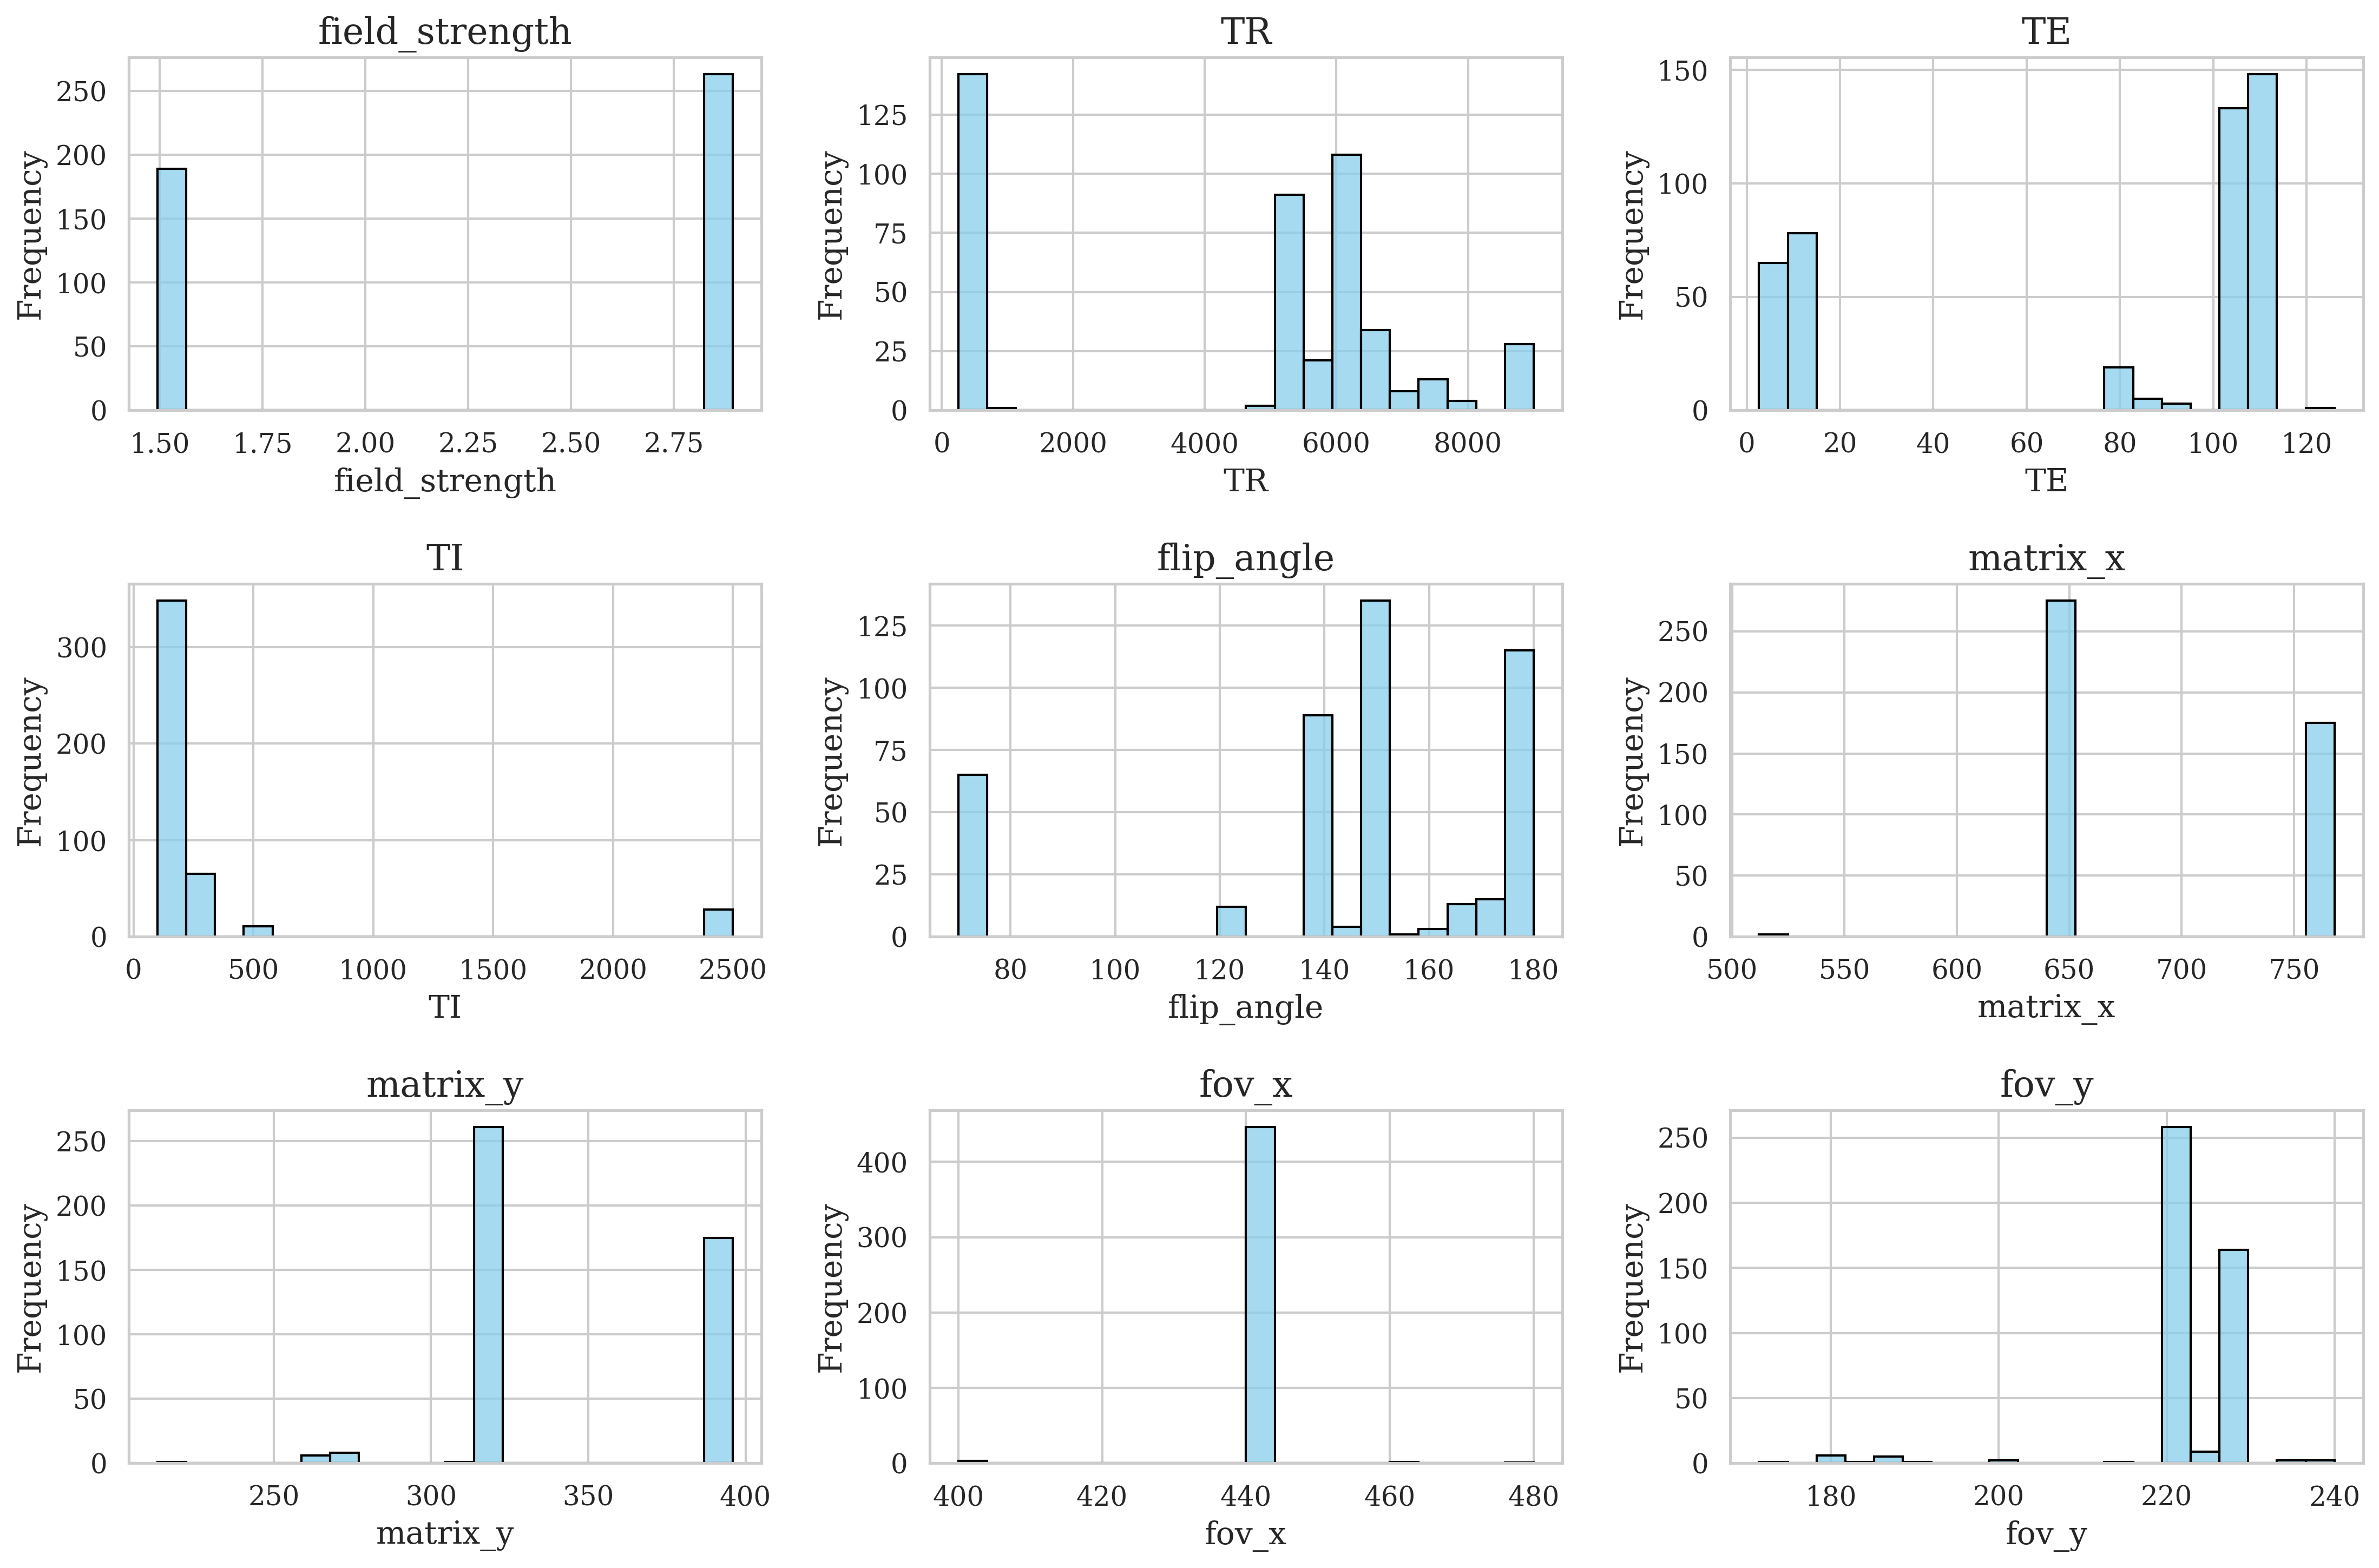

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted", font_scale=1.5)
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
})

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for i, key in enumerate(continuous_keys):
    data = df[key].dropna()
    sns.histplot(data, bins=20, kde=False, ax=axs[i], color='skyblue', edgecolor='black')
    axs[i].set_title(key)
    axs[i].set_xlabel(key)
    axs[i].set_ylabel("Frequency")

for j in range(len(continuous_keys), len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()

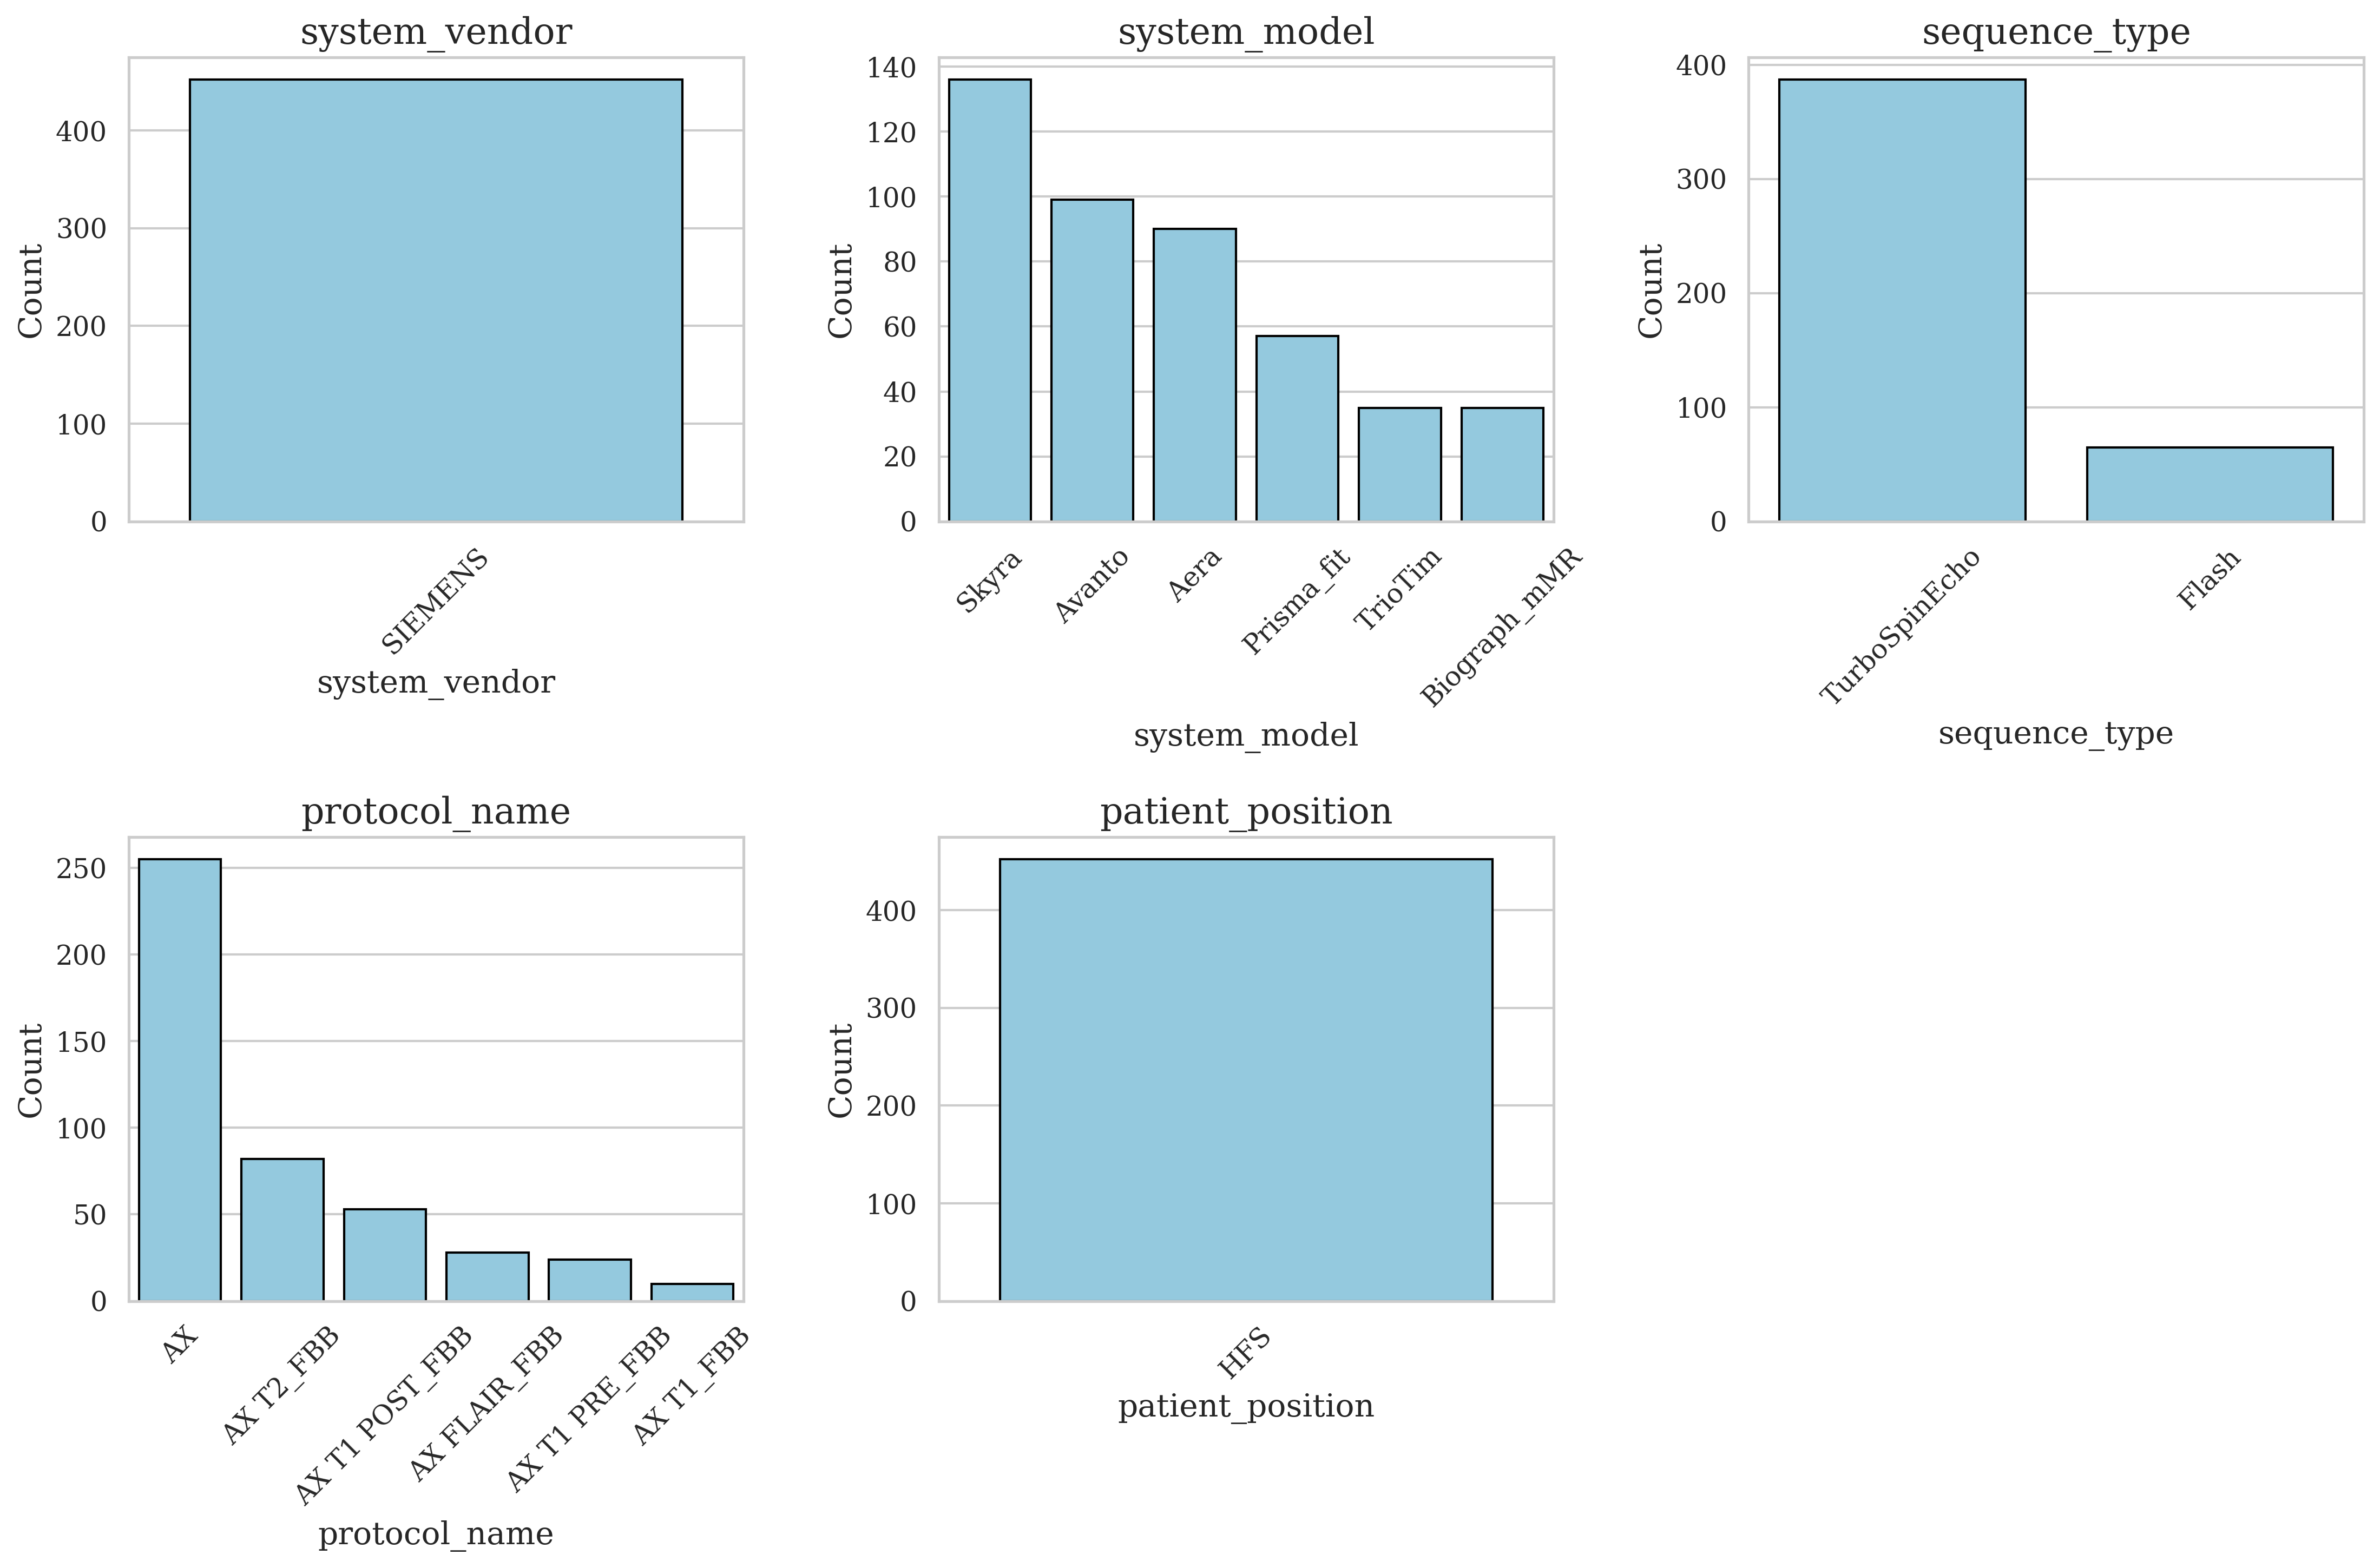

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, key in enumerate(categorical_keys):
    counts = df[key].value_counts(dropna=False)
    sns.barplot(
        x=counts.index.astype(str), 
        y=counts.values, 
        ax=axs[i], 
        color='skyblue', 
        edgecolor='black'
    )
    axs[i].set_title(key)
    axs[i].set_xlabel(key)
    axs[i].set_ylabel("Count")
    axs[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_keys), len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()